In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import os.path
import random as pyr
import sys
import tarfile
import argparse
import re
import simplejson
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import matplotlib as mpl
import pprint
import tarfile
import time
from collections import Counter

In [3]:
cocotext = simplejson.load(open("cocotext.v2.json"))

In [4]:
cocotext.keys()

dict_keys(['cats', 'anns', 'imgs', 'imgToAnns', 'info'])

In [5]:
list(cocotext["imgs"].items())[0]

('540965',
 {'id': 540965,
  'set': 'train',
  'width': 640,
  'file_name': 'COCO_train2014_000000540965.jpg',
  'height': 360})

In [6]:
list(cocotext["anns"].items())[0]

('45346',
 {'mask': [468.9, 286.7, 468.9, 295.2, 493.0, 295.8, 493.0, 287.2],
  'class': 'machine printed',
  'bbox': [468.9, 286.7, 24.1, 9.1],
  'image_id': 217925,
  'id': 45346,
  'language': 'english',
  'area': 206.06,
  'utf8_string': 'New',
  'legibility': 'legible'})

In [7]:
imgs = {int(k): v for k, v in cocotext["imgs"].items()}
anns = {int(k): v for k, v in cocotext["anns"].items()}
for a in anns.values():
    a.update(imgs[a["image_id"]])

In [8]:
{a["image_id"] for a in anns.values()} - set(imgs.keys())

set()

In [9]:
{a["legibility"] for a in anns.values()}

{'illegible', 'legible'}

In [117]:
{a["set"] for a in anns.values()}

{'train', 'val'}

In [129]:
def ann_test(a):
    if a["legibility"] != "legible": return False
    if a["language"] != "english": return False
    x, y, w, h = [int(q) for q in a['bbox']]
    if len(a["utf8_string"]) < 2: return False
    if w<20: return False
    if h<10: return False
    if h>w: return False
    return True
good = [a for a in anns.values() if ann_test(a)]
len(good)

36553

In [130]:
random.shuffle(good)

{'mask': [79.1, 246.2, 80.2, 258.4, 131.7, 260.0, 130.7, 246.7], 'class': 'machine printed', 'bbox': [79.1, 246.2, 52.6, 13.8], 'image_id': 268102, 'id': 268102, 'language': 'english', 'area': 656.16, 'utf8_string': '1:26.821', 'legibility': 'legible', 'set': 'train', 'width': 612, 'file_name': 'COCO_train2014_000000268102.jpg', 'height': 612}


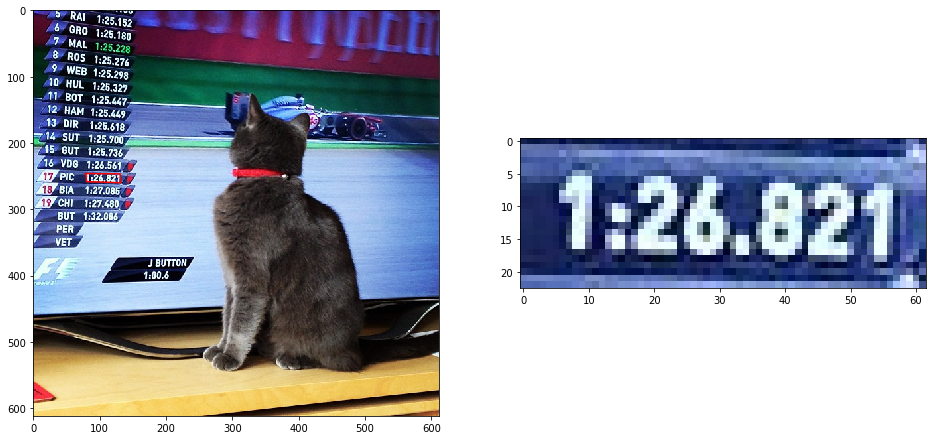

In [131]:
for an in good:
    print(an)
    x, y, w, h = [int(q) for q in an['bbox']]
    s = "val" if "val" in an['file_name'] else "train"
    image = imread(f"/data1/coco-extract/{s}2014/{an['file_name']}")
    figsize(16, 8); subplot(121); imshow(image)
    mask = an["mask"]
    plot(mask[::2]+mask[:1], mask[1::2]+mask[1:2], color="red")
    #scatter([x], [y], color="red", marker="+")
    pad = 5
    sub = image[y-pad:y+h+pad, x-pad:x+w+pad]
    subplot(122); imshow(sub)
    break

In [133]:
from webdataset import writer

In [139]:
train = writer.ShardWriter("coco-text-rect-train-%06d.tar")
val = writer.ShardWriter("coco-text-rect-val-%06d.tar")

for index, an in enumerate(good):
    x, y, w, h = [int(q) for q in an['bbox']]
    s = "val" if "val" in an['file_name'] else "train"
    image = imread(f"/data1/coco-extract/{s}2014/{an['file_name']}")
    pad = 5
    sub = image[max(0,y-pad):y+h+pad, max(0,x-pad):x+w+pad]
    key = re.sub(r"(?i)\.(png|jpg)$", "", an["file_name"])+f"/{x},{y},{w},{h}"
    sample = dict(__key__=key, png=sub, text=an["utf8_string"])
    if an["set"]=="val":
        val.write(sample)
    else:
        train.write(sample)
    if index%1000==0: print(index, key, sub.shape, sample["text"], file=sys.stderr)

val.close()
train.close()

# writing coco-text-rect-train-000000.tar 0 0.0 GB 0
# writing coco-text-rect-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000268102/79,246,52,13 (23, 62, 3) 1:26.821
1000 COCO_train2014_000000287378/371,218,71,27 (37, 81, 3) BUND
2000 COCO_train2014_000000435814/589,297,25,22 (32, 35, 3) RI
3000 COCO_train2014_000000198654/371,209,36,12 (22, 46, 3) HARRIS
4000 COCO_train2014_000000068003/191,152,72,28 (38, 82, 3) MEN
5000 COCO_train2014_000000036725/465,387,51,15 (25, 61, 3) Photography
6000 COCO_train2014_000000511580/54,478,36,10 (20, 46, 3) lemon
7000 COCO_train2014_000000128328/450,233,24,21 (31, 34, 3) ROW
8000 COCO_train2014_000000578775/4,15,111,12 (22, 120, 3) Tim
9000 COCO_train2014_000000219855/18,407,43,15 (25, 53, 3) MAV
10000 COCO_train2014_000000131902/420,323,37,16 (26, 47, 3) HONDA
11000 COCO_train2014_000000361480/180,250,21,12 (22, 31, 3) TOUR
12000 COCO_train2014_000000074515/303,222,55,28 (38, 65, 3) ROMA
13000 COCO_train2014_000000231874/221,317,96,39 (49, 106, 3) WILL
14000 COCO_train2014_000000341916/465,239,23,10 (20, 33, 3) C-GCHD
15000 COCO_train2014_000000547

Columbus


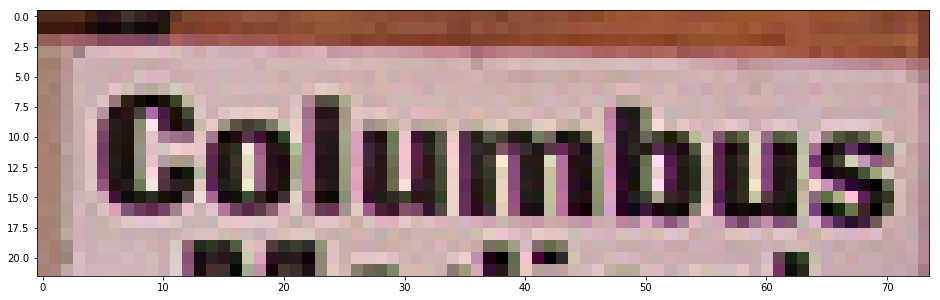

In [141]:
imshow(sub); print(an["utf8_string"])

In [203]:
def bboxarea(points):
    return float((amax(points[:,0])-amin(points[:,0])) * (amax(points[:,1])-amin(points[:,1])))

def mask2points(mask, center=False):
    points = zeros((len(mask)//2, 2))
    points[:, 0] = mask[1::2]
    points[:, 1] = mask[0::2] 
    if center:
        points = points - mean(points, 0)[None, :]
    return points

def rot2(alpha):
    return array([[cos(alpha), -sin(alpha)], [sin(alpha), cos(alpha)]])

def bestrot(points, lo=-0.7, hi=0.7, nsteps=200):
    alphas = linspace(lo, hi, nsteps)
    def f(alpha):
        return bboxarea(dot(points, rot2(alpha)))
    #print(alphas)
    areas = list(map(f, alphas))
    #print(areas)
    #plot(alphas, areas)
    index = argmin(areas)
    return -alphas[index]

from math import atan2
def orientation(mask):
    """Compute orientation of a collection of points."""
    H = dot(points.T, points)
    s, m = eig(H)
    #print(s, m)
    i = argmax(s)
    v = m[:,i]
    if v[1]<0: v = -v
    return atan2(v[0], v[1])

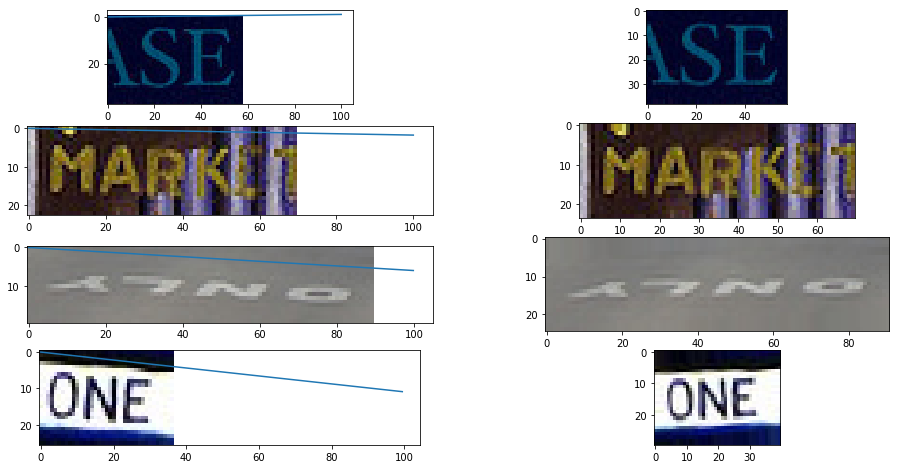

In [210]:
l = list(good)
random.shuffle(l)
for i, an in enumerate(l[:4]):
    image = imread(f"/data1/coco-extract/{s}2014/{an['file_name']}")
    x, y, w, h = [int(q) for q in an['bbox']]
    sub = image[max(0,y-pad):y+h+pad, max(0,x-pad):x+w+pad]
    mask = an["mask"]
    alpha = bestrot(mask2points(mask))
    #break
    #plot(mask[::2], mask[1::2], color="red", marker="+")
    rsub = ndi.rotate(sub, alpha*180/pi, order=2, mode="nearest")
    subplot(4,2,2*i+1) 
    imshow(sub)
    plot([0, 100*cos(alpha)], [0, 100*sin(alpha)])
    subplot(4,2,2*i+2)
    imshow(rsub)

# writing coco-text-rot-train-000000.tar 0 0.0 GB 0
# writing coco-text-rot-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000268102/79,246,52,13 (24, 62, 3) 1:26.821
1000 COCO_train2014_000000287378/371,218,71,27 (41, 83, 3) BUND
2000 COCO_train2014_000000435814/589,297,25,22 (33, 36, 3) RI
3000 COCO_train2014_000000198654/371,209,36,12 (25, 47, 3) HARRIS
4000 COCO_train2014_000000068003/191,152,72,28 (43, 84, 3) MEN
5000 COCO_train2014_000000036725/465,387,51,15 (26, 62, 3) Photography
6000 COCO_train2014_000000511580/54,478,36,10 (22, 47, 3) lemon
7000 COCO_train2014_000000128328/450,233,24,21 (42, 44, 3) ROW
8000 COCO_train2014_000000578775/4,15,111,12 (22, 120, 3) Tim
9000 COCO_train2014_000000219855/18,407,43,15 (27, 54, 3) MAV
10000 COCO_train2014_000000131902/420,323,37,16 (33, 50, 3) HONDA
11000 COCO_train2014_000000361480/180,250,21,12 (22, 31, 3) TOUR
12000 COCO_train2014_000000074515/303,222,55,28 (55, 73, 3) ROMA
13000 COCO_train2014_000000231874/221,317,96,39 (49, 106, 3) WILL
14000 COCO_train2014_000000341916/465,239,23,10 (25, 36, 3) C-GCHD
15000 COCO_train2014_000000547

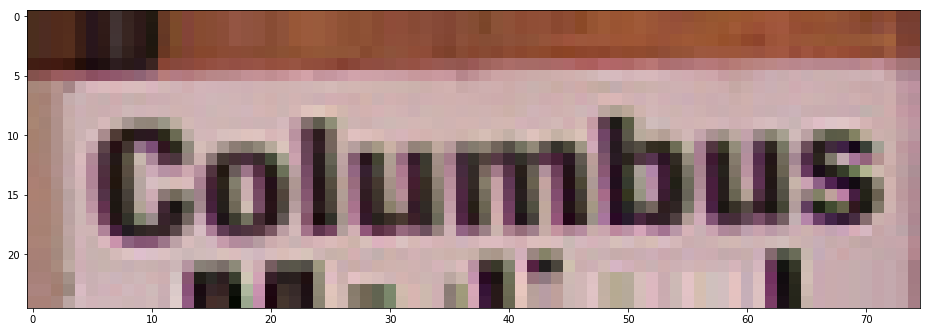

In [211]:
train = writer.ShardWriter("coco-text-rot-train-%06d.tar")
val = writer.ShardWriter("coco-text-rot-val-%06d.tar")

for index, an in enumerate(good):
    x, y, w, h = [int(q) for q in an['bbox']]
    s = "val" if "val" in an['file_name'] else "train"
    image = imread(f"/data1/coco-extract/{s}2014/{an['file_name']}")
    pad = 5
    sub = image[max(0,y-pad):y+h+pad, max(0,x-pad):x+w+pad]
    alpha = bestrot(mask2points(an["mask"]))
    sub = ndi.rotate(sub, alpha*180/pi, order=1, mode="nearest")
    key = re.sub(r"(?i)\.(png|jpg)$", "", an["file_name"])+f"/{x},{y},{w},{h}"
    sample = dict(__key__=key, png=sub, text=an["utf8_string"])
    if an["set"]=="val":
        val.write(sample)
    else:
        train.write(sample)
    if index%1000==0: print(index, key, sub.shape, sample["text"], file=sys.stderr)

val.close()
train.close()
                   
imshow(sub)

In [ ]:
imshow(sub); print(an["utf8_string"])

In [239]:
import scipy.ndimage as ndi
def mrot(a):
    """Make a rotation matrix."""
    return array([[cos(a), -sin(a)], [sin(a), cos(a)]])
def eye23(m):
    """2D to 3D matrix"""
    result = eye(3)
    result[:2, :2] = m
    return result
def off23(d):
    """2D to 3D offset"""
    result = zeros(3)
    result[:2] = d
    return result
def make_affine(src, dst):
    """Compute affine transformation from src to dst points."""
    dst0 = dst - mean(dst, 0)[None, :]
    src0 = src - mean(src, 0)[None, :]
    H = dot(dst0.T, src0)
    U, S, V = svd(H)
    m = dot(V.T, U)
    d = dot(m, mean(dst, 0)) - mean(src, 0)
    #print(d)
    return m, d
def extract_masked(image, mask, dalpha=uniform(-.3, .3), r=0.1, pad=5, p0=1):
    """Given a polygonal mask for text, extract a text image at random rotations and padding."""
    coords = zeros((len(mask)//2, 2))
    coords[:, 0] = mask[1::2]
    coords[:, 1] = mask[0::2]
    alpha = bestrot(mask2points(mask))
    ncoords = dot(coords, uniform(0.8, 1.2)*( mrot(-alpha)+uniform(-r, r, size=(2, 2))))
    ncoords -= array([amin(ncoords[:,0])-randint(p0, pad), amin(ncoords[:,1])-randint(p0, pad)])
    h, w = int(amax(ncoords[:,0]))+randint(p0, pad), int(amax(ncoords[:,1]))+randint(p0, pad)
    make_affine(coords, ncoords)
    m, d = make_affine(coords, ncoords)
    return ndi.affine_transform(image, eye23(m), offset=-off23(d), output_shape=(h, w, 3))

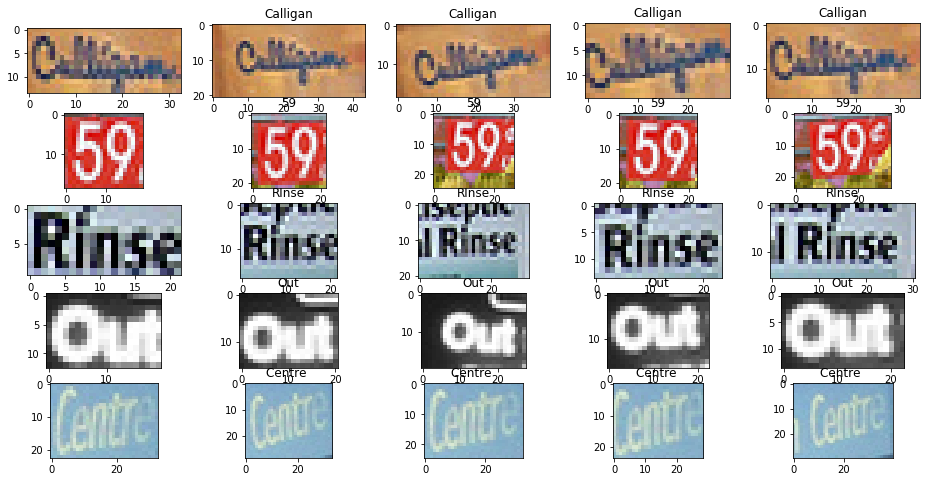

In [241]:
l = list(good)
random.shuffle(l)

for index, an in enumerate(l[:5]):
    s = "val" if "val" in an['file_name'] else "train"
    image = imread(f"/data1/coco-extract/{s}2014/{an['file_name']}")
    subplot(5, 5, index*5+1)
    x, y, w, h = [int(q) for q in an['bbox']]
    pad = 0
    sub = image[max(0,y-pad):y+h+pad, max(0,x-pad):x+w+pad]
    imshow(sub)
    for i in range(4):
        subplot(5, 5, index*5+i+2)
        title(an["utf8_string"])
        sub = extract_masked(image, an["mask"])
        imshow(sub)

# writing coco-text-affine-000-train-000000.tar 0 0.0 GB 0
# writing coco-text-affine-000-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000318154/161,298,59,16 (21, 59, 3) Ramen


0 175 affine matrix has wrong number of columns
0 368 affine matrix has wrong number of columns


1000 COCO_train2014_000000068194/296,199,128,17 (31, 128, 3) SKYFALL


0 1160 affine matrix has wrong number of columns
0 1209 affine matrix has wrong number of columns
0 1326 affine matrix has wrong number of columns


2000 COCO_train2014_000000457035/448,377,29,11 (9, 37, 3) DAF
3000 COCO_train2014_000000054345/203,235,50,12 (19, 72, 3) FRANCISCO


0 3227 affine matrix has wrong number of columns
0 3343 affine matrix has wrong number of columns
0 3755 affine matrix has wrong number of columns
0 3756 affine matrix has wrong number of columns


4000 COCO_train2014_000000301156/319,98,131,22 (30, 172, 3) VOLUNTEER SPECIAL OPERATIONS


0 4440 affine matrix has wrong number of columns


5000 COCO_train2014_000000024585/174,241,61,30 (32, 56, 3) gin


0 5411 affine matrix has wrong number of columns
0 5434 affine matrix has wrong number of columns
0 5986 affine matrix has wrong number of columns


6000 COCO_train2014_000000541094/374,171,58,25 (24, 63, 3) ejandro


0 6041 affine matrix has wrong number of columns
0 6639 affine matrix has wrong number of columns


7000 COCO_train2014_000000504748/455,235,48,19 (22, 55, 3) MUCH


0 7619 affine matrix has wrong number of columns
0 7832 affine matrix has wrong number of columns


8000 COCO_train2014_000000171082/390,176,62,29 (24, 61, 3) Road


0 8034 affine matrix has wrong number of columns
0 8937 affine matrix has wrong number of columns


9000 COCO_train2014_000000557824/91,255,79,52 (67, 99, 3) Before


0 9203 affine matrix has wrong number of columns
0 9435 affine matrix has wrong number of columns


10000 COCO_train2014_000000566432/130,49,33,11 (9, 37, 3) SONY


0 10354 affine matrix has wrong number of columns
0 10383 affine matrix has wrong number of columns
0 10406 affine matrix has wrong number of columns
0 10408 affine matrix has wrong number of columns
0 10591 affine matrix has wrong number of columns
0 10915 affine matrix has wrong number of columns


11000 COCO_train2014_000000381985/14,399,24,12 (19, 36, 3) LC


0 11106 affine matrix has wrong number of columns
0 11395 affine matrix has wrong number of columns
0 11665 affine matrix has wrong number of columns
0 11989 affine matrix has wrong number of columns


12000 COCO_train2014_000000110819/144,191,29,16 (20, 30, 3) UISP


0 12247 affine matrix has wrong number of columns
0 12330 affine matrix has wrong number of columns
0 12688 affine matrix has wrong number of columns


13000 COCO_train2014_000000185247/93,415,63,12 (17, 54, 3) Healthrow


0 13444 affine matrix has wrong number of columns


14000 COCO_train2014_000000445775/375,163,53,26 (22, 54, 3) Theatre


0 14075 affine matrix has wrong number of columns
0 14285 affine matrix has wrong number of columns
0 14301 affine matrix has wrong number of columns
0 14765 affine matrix has wrong number of columns


15000 COCO_train2014_000000022080/273,168,28,10 (16, 37, 3) CAFE


0 15529 affine matrix has wrong number of columns
0 15644 affine matrix has wrong number of columns


16000 COCO_train2014_000000259464/307,43,50,30 (30, 49, 3) PCCP
17000 COCO_train2014_000000086292/143,234,58,18 (26, 71, 3) ellesse
18000 COCO_train2014_000000415901/315,180,43,35 (28, 56, 3) KENSIN


0 18046 affine matrix has wrong number of columns
0 18083 affine matrix has wrong number of columns
0 18222 affine matrix has wrong number of columns
0 18595 affine matrix has wrong number of columns


19000 COCO_train2014_000000154801/36,145,120,44 (57, 125, 3) brunch


0 19024 affine matrix has wrong number of columns


20000 COCO_train2014_000000571654/12,395,24,14 (19, 31, 3) Box
21000 COCO_train2014_000000530282/139,220,66,21 (25, 82, 3) SOUTHFLEET


0 21220 affine matrix has wrong number of columns
0 21553 affine matrix has wrong number of columns


22000 COCO_train2014_000000477852/48,398,26,10 (13, 29, 3) Laurent
23000 COCO_train2014_000000334431/172,147,37,13 (16, 42, 3) ious


0 23025 affine matrix has wrong number of columns
0 23430 affine matrix has wrong number of columns
0 23711 affine matrix has wrong number of columns


24000 COCO_train2014_000000076784/330,357,44,15 (16, 51, 3) VOLCO


0 24427 affine matrix has wrong number of columns
0 24813 affine matrix has wrong number of columns


25000 COCO_train2014_000000417090/10,320,60,16 (20, 69, 3) THERSBHY


0 25029 affine matrix has wrong number of columns
0 25088 affine matrix has wrong number of columns


26000 COCO_train2014_000000233292/235,108,78,21 (30, 100, 3) HORNIG


0 26331 affine matrix has wrong number of columns
0 26573 affine matrix has wrong number of columns


27000 COCO_train2014_000000549471/207,335,60,12 (20, 76, 3) B3717BFV


0 27201 affine matrix has wrong number of columns
0 27905 affine matrix has wrong number of columns
0 27967 affine matrix has wrong number of columns


28000 COCO_train2014_000000187976/237,101,37,15 (17, 34, 3) 378


0 28293 affine matrix has wrong number of columns


29000 COCO_train2014_000000439493/180,264,21,16 (18, 23, 3) 54


0 29160 affine matrix has wrong number of columns


30000 COCO_train2014_000000293277/172,155,21,21 (21, 26, 3) Easy


0 30993 affine matrix has wrong number of columns


31000 COCO_train2014_000000167862/289,68,34,26 (19, 45, 3) DEMO


0 31763 affine matrix has wrong number of columns


32000 COCO_train2014_000000353754/356,91,34,24 (28, 42, 3) Ford
33000 COCO_train2014_000000334637/413,386,54,23 (19, 65, 3) COMBO


0 33037 affine matrix has wrong number of columns
0 33955 affine matrix has wrong number of columns


34000 COCO_train2014_000000524676/240,137,151,29 (35, 167, 3) SULPHUR


0 34258 affine matrix has wrong number of columns
0 34611 affine matrix has wrong number of columns
0 34938 affine matrix has wrong number of columns
0 34995 affine matrix has wrong number of columns


35000 COCO_train2014_000000123711/14,13,189,20 (35, 177, 3) WWW.MAVERIX.ORG


0 35302 affine matrix has wrong number of columns


36000 COCO_train2014_000000309461/168,236,66,43 (52, 74, 3) yall


0 36504 affine matrix has wrong number of columns
# writing coco-text-affine-001-train-000000.tar 0 0.0 GB 0
# writing coco-text-affine-001-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000285002/518,103,70,12 (14, 64, 3) KONTIKON


1 84 affine matrix has wrong number of columns
1 645 affine matrix has wrong number of columns
1 662 affine matrix has wrong number of columns


1000 COCO_train2014_000000272176/460,248,37,21 (18, 45, 3) LAGER


1 1060 affine matrix has wrong number of columns
1 1277 affine matrix has wrong number of columns
1 1671 affine matrix has wrong number of columns
1 1940 affine matrix has wrong number of columns


2000 COCO_train2014_000000114363/385,142,24,20 (16, 29, 3) RUE


1 2624 affine matrix has wrong number of columns


3000 COCO_train2014_000000521899/467,402,38,12 (21, 43, 3) HAPPY


1 3139 affine matrix has wrong number of columns
1 3247 affine matrix has wrong number of columns
1 3616 affine matrix has wrong number of columns


4000 COCO_train2014_000000274978/554,422,51,15 (22, 54, 3) guijarro


1 4758 affine matrix has wrong number of columns


5000 COCO_train2014_000000515853/387,182,51,19 (18, 48, 3) SIGHTSEEING


1 5648 affine matrix has wrong number of columns
1 5946 affine matrix has wrong number of columns


6000 COCO_train2014_000000347419/238,315,57,34 (20, 59, 3) ZS


1 6205 affine matrix has wrong number of columns
1 6519 affine matrix has wrong number of columns
1 6644 affine matrix has wrong number of columns
1 6967 affine matrix has wrong number of columns


7000 COCO_train2014_000000110111/11,88,33,11 (19, 40, 3) FREE


1 7878 affine matrix has wrong number of columns


8000 COCO_train2014_000000136346/557,424,73,19 (32, 83, 3) panaligan


1 8131 affine matrix has wrong number of columns
1 8994 affine matrix has wrong number of columns


9000 COCO_train2014_000000131067/462,0,89,58 (86, 46, 3) NT


1 9359 affine matrix has wrong number of columns
1 9677 affine matrix has wrong number of columns
1 9951 affine matrix has wrong number of columns


10000 COCO_train2014_000000537055/30,18,83,20 (19, 70, 3) DOUGH


1 10785 affine matrix has wrong number of columns


11000 COCO_train2014_000000547618/436,181,31,11 (15, 41, 3) SUGAR


1 11721 affine matrix has wrong number of columns


12000 COCO_train2014_000000105388/307,98,38,12 (17, 43, 3) JOHN


1 12786 affine matrix has wrong number of columns
1 12854 affine matrix has wrong number of columns


13000 COCO_train2014_000000147520/119,154,39,16 (24, 49, 3) 526


1 13106 affine matrix has wrong number of columns
1 13288 affine matrix has wrong number of columns
1 13560 affine matrix has wrong number of columns
1 13842 affine matrix has wrong number of columns
1 13964 affine matrix has wrong number of columns
1 13987 affine matrix has wrong number of columns


14000 COCO_train2014_000000563711/174,309,55,23 (24, 56, 3) BOST


1 14003 affine matrix has wrong number of columns
1 14487 affine matrix has wrong number of columns
1 14629 affine matrix has wrong number of columns


15000 COCO_train2014_000000365206/407,178,34,13 (18, 34, 3) Comedy


1 15720 affine matrix has wrong number of columns


16000 COCO_train2014_000000021330/151,277,167,66 (72, 179, 3) STOP
17000 COCO_train2014_000000076784/330,357,44,15 (19, 47, 3) VOLCO


1 17716 affine matrix has wrong number of columns


18000 COCO_train2014_000000225383/255,268,36,12 (13, 37, 3) 377 467


1 18206 affine matrix has wrong number of columns
1 18586 affine matrix has wrong number of columns


19000 COCO_train2014_000000140575/271,194,168,17 (35, 176, 3) DODGE
20000 COCO_train2014_000000370760/385,345,22,10 (13, 34, 3) Visit


1 20387 affine matrix has wrong number of columns


21000 COCO_train2014_000000479591/64,118,67,23 (23, 85, 3) Beattie


1 21179 affine matrix has wrong number of columns
1 21243 affine matrix has wrong number of columns


22000 COCO_train2014_000000504861/4,37,68,13 (21, 69, 3) ventilation.


1 22317 affine matrix has wrong number of columns
1 22581 affine matrix has wrong number of columns
1 22590 affine matrix has wrong number of columns


23000 COCO_train2014_000000183007/309,261,42,13 (21, 57, 3) Granby
24000 COCO_train2014_000000151900/428,244,41,13 (14, 38, 3) FLUXX


1 24309 affine matrix has wrong number of columns


25000 COCO_train2014_000000226294/256,278,57,24 (26, 72, 3) there


1 25475 affine matrix has wrong number of columns
1 25553 affine matrix has wrong number of columns


26000 COCO_train2014_000000234244/602,169,36,13 (16, 45, 3) TMNT


1 26552 affine matrix has wrong number of columns
1 26609 affine matrix has wrong number of columns
1 26682 affine matrix has wrong number of columns


27000 COCO_train2014_000000453697/95,222,31,15 (15, 38, 3) LOVE


1 27508 affine matrix has wrong number of columns


28000 COCO_train2014_000000443427/63,459,41,12 (13, 42, 3) Georg
29000 COCO_train2014_000000467081/214,473,28,20 (24, 33, 3) OK


1 29620 affine matrix has wrong number of columns


30000 COCO_train2014_000000361659/146,42,82,49 (57, 103, 3) CYKEL


1 30147 affine matrix has wrong number of columns
1 30446 affine matrix has wrong number of columns
1 30542 affine matrix has wrong number of columns
1 30570 affine matrix has wrong number of columns


31000 COCO_train2014_000000525039/417,199,21,15 (22, 31, 3) THE


1 31344 affine matrix has wrong number of columns
1 31391 affine matrix has wrong number of columns


32000 COCO_train2014_000000422343/198,133,33,10 (14, 37, 3) MENU


1 32019 affine matrix has wrong number of columns
1 32136 affine matrix has wrong number of columns
1 32176 affine matrix has wrong number of columns
1 32351 affine matrix has wrong number of columns
1 32360 affine matrix has wrong number of columns


33000 COCO_train2014_000000193095/252,426,50,12 (18, 68, 3) PUERTA


1 33205 affine matrix has wrong number of columns
1 33289 affine matrix has wrong number of columns
1 33856 affine matrix has wrong number of columns


34000 COCO_train2014_000000350170/198,141,34,14 (24, 42, 3) CAPS


1 34502 affine matrix has wrong number of columns


35000 COCO_train2014_000000005483/510,218,46,25 (13, 56, 3) Croissant


1 35091 affine matrix has wrong number of columns


36000 COCO_train2014_000000013983/356,227,56,13 (16, 65, 3) PIZZA


1 36466 affine matrix has wrong number of columns
# writing coco-text-affine-002-train-000000.tar 0 0.0 GB 0
# writing coco-text-affine-002-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000177807/302,214,23,23 (22, 28, 3) OK
1000 COCO_train2014_000000178207/322,87,28,10 (16, 30, 3) Gratta


2 1154 affine matrix has wrong number of columns
2 1521 affine matrix has wrong number of columns
2 1800 affine matrix has wrong number of columns
2 1813 affine matrix has wrong number of columns


2000 COCO_train2014_000000100503/298,252,234,67 (48, 203, 3) STREET


2 2229 affine matrix has wrong number of columns
2 2749 affine matrix has wrong number of columns
2 2777 affine matrix has wrong number of columns


3000 COCO_train2014_000000542779/223,170,36,14 (17, 40, 3) EAST
4000 COCO_train2014_000000222101/86,11,35,23 (31, 52, 3) sfx


2 4045 affine matrix has wrong number of columns


5000 COCO_train2014_000000241723/188,413,110,49 (43, 104, 3) California


2 5026 affine matrix has wrong number of columns
2 5331 affine matrix has wrong number of columns


6000 COCO_train2014_000000173887/210,302,59,23 (34, 71, 3) FOR


2 6116 affine matrix has wrong number of columns
2 6503 affine matrix has wrong number of columns
2 6694 affine matrix has wrong number of columns


7000 COCO_train2014_000000459082/441,121,35,20 (29, 41, 3) 99


2 7471 affine matrix has wrong number of columns
2 7834 affine matrix has wrong number of columns


8000 COCO_train2014_000000527748/370,491,23,10 (15, 22, 3) wxyz


2 8711 affine matrix has wrong number of columns


9000 COCO_train2014_000000020182/538,85,101,20 (19, 93, 3) LOCHALS


2 9162 affine matrix has wrong number of columns
2 9163 affine matrix has wrong number of columns
2 9640 affine matrix has wrong number of columns


10000 COCO_train2014_000000256778/104,206,33,14 (21, 36, 3) GMC


2 10756 affine matrix has wrong number of columns


11000 COCO_train2014_000000201278/364,6,46,17 (20, 52, 3) Huang


2 11344 affine matrix has wrong number of columns


12000 COCO_train2014_000000295461/434,126,28,11 (16, 35, 3) Edgware


2 12068 affine matrix has wrong number of columns
2 12354 affine matrix has wrong number of columns


13000 COCO_train2014_000000284008/470,531,62,20 (23, 55, 3) Holmes


2 13466 affine matrix has wrong number of columns


14000 COCO_train2014_000000271791/228,83,84,72 (31, 102, 3) (01989) 564505


2 14080 affine matrix has wrong number of columns
2 14533 affine matrix has wrong number of columns


15000 COCO_train2014_000000397792/262,335,37,22 (20, 37, 3) Citia


2 15028 affine matrix has wrong number of columns
2 15610 affine matrix has wrong number of columns
2 15631 affine matrix has wrong number of columns
2 15857 affine matrix has wrong number of columns


16000 COCO_train2014_000000433910/89,257,24,10 (15, 30, 3) ENOAST


2 16226 affine matrix has wrong number of columns
2 16459 affine matrix has wrong number of columns
2 16477 affine matrix has wrong number of columns
2 16511 affine matrix has wrong number of columns


17000 COCO_train2014_000000536204/354,524,119,12 (20, 138, 3) winterbourne


2 17207 affine matrix has wrong number of columns
2 17388 affine matrix has wrong number of columns
2 17616 affine matrix has wrong number of columns


18000 COCO_train2014_000000492478/213,374,20,11 (14, 28, 3) BIR


2 18083 affine matrix has wrong number of columns
2 18203 affine matrix has wrong number of columns
2 18409 affine matrix has wrong number of columns


19000 COCO_train2014_000000056715/357,204,31,17 (20, 41, 3) Cross


2 19466 affine matrix has wrong number of columns
2 19530 affine matrix has wrong number of columns


20000 COCO_train2014_000000345914/74,54,27,12 (19, 32, 3) bleu
21000 COCO_train2014_000000554301/313,294,82,24 (29, 93, 3) SAMUEL


2 21099 affine matrix has wrong number of columns
2 21440 affine matrix has wrong number of columns
2 21676 affine matrix has wrong number of columns
2 21975 affine matrix has wrong number of columns


22000 COCO_train2014_000000043780/481,409,125,21 (38, 140, 3) 09/14/2007


2 22722 affine matrix has wrong number of columns


23000 COCO_train2014_000000543392/224,226,81,20 (31, 91, 3) HOUSE


2 23255 affine matrix has wrong number of columns
2 23385 affine matrix has wrong number of columns


24000 COCO_train2014_000000536920/267,54,80,65 (30, 100, 3) TRIK
25000 COCO_train2014_000000145570/500,288,66,25 (35, 62, 3) 667-


2 25716 affine matrix has wrong number of columns


26000 COCO_train2014_000000151345/299,303,44,20 (21, 56, 3) cortech


2 26107 affine matrix has wrong number of columns


27000 COCO_train2014_000000365958/458,92,42,24 (37, 53, 3) 114


2 27689 affine matrix has wrong number of columns
2 27762 affine matrix has wrong number of columns


28000 COCO_train2014_000000282926/289,122,112,18 (35, 122, 3) www.rolandgarros.com


2 28537 affine matrix has wrong number of columns
2 28653 affine matrix has wrong number of columns


29000 COCO_train2014_000000482079/543,459,70,10 (21, 70, 3) Landsiedel


2 29043 affine matrix has wrong number of columns
2 29095 affine matrix has wrong number of columns
2 29158 affine matrix has wrong number of columns
2 29773 affine matrix has wrong number of columns
2 29888 affine matrix has wrong number of columns


30000 COCO_train2014_000000506429/373,377,37,16 (24, 43, 3) .com?


2 30287 affine matrix has wrong number of columns
2 30971 affine matrix has wrong number of columns


31000 COCO_train2014_000000511412/387,227,99,29 (37, 100, 3) MONKEY
32000 COCO_train2014_000000440877/72,176,58,44 (48, 58, 3) CREATE


2 32219 affine matrix has wrong number of columns
2 32635 affine matrix has wrong number of columns


33000 COCO_train2014_000000132591/544,239,47,14 (17, 44, 3) SEXWAX


2 33574 affine matrix has wrong number of columns


34000 COCO_train2014_000000048664/105,147,61,47 (32, 88, 3) Dolce


2 34192 affine matrix has wrong number of columns
2 34534 affine matrix has wrong number of columns
2 34758 affine matrix has wrong number of columns
2 34892 affine matrix has wrong number of columns


35000 COCO_train2014_000000434328/349,255,56,21 (24, 50, 3) and


2 35222 affine matrix has wrong number of columns
2 35492 affine matrix has wrong number of columns
2 35688 affine matrix has wrong number of columns


36000 COCO_train2014_000000365175/350,27,27,18 (17, 31, 3) 350


# writing coco-text-affine-003-train-000000.tar 0 0.0 GB 0
# writing coco-text-affine-003-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000062864/304,244,128,92 (107, 143, 3) OK
1000 COCO_train2014_000000193077/195,514,39,13 (22, 54, 3) FULL
2000 COCO_train2014_000000049603/96,198,344,102 (114, 396, 3) BNP
3000 COCO_train2014_000000000142/283,265,78,21 (22, 83, 3) Chocolate


3 3020 affine matrix has wrong number of columns
3 3978 affine matrix has wrong number of columns


4000 COCO_train2014_000000364361/398,429,35,15 (21, 40, 3) FOOD


3 4259 affine matrix has wrong number of columns
3 4267 affine matrix has wrong number of columns


5000 COCO_train2014_000000055232/529,39,65,12 (18, 74, 3) MARGARIT


3 5305 affine matrix has wrong number of columns
3 5443 affine matrix has wrong number of columns
3 5707 affine matrix has wrong number of columns
3 5929 affine matrix has wrong number of columns
3 5967 affine matrix has wrong number of columns


6000 COCO_train2014_000000044388/243,0,42,15 (22, 40, 3) syfresh


3 6291 affine matrix has wrong number of columns


7000 COCO_train2014_000000579414/7,133,68,24 (36, 75, 3) HSBC


3 7122 affine matrix has wrong number of columns
3 7550 affine matrix has wrong number of columns


8000 COCO_train2014_000000331474/192,109,35,26 (29, 37, 3) 23
9000 COCO_train2014_000000357733/258,89,34,15 (17, 45, 3) 1800


3 9171 affine matrix has wrong number of columns
3 9513 affine matrix has wrong number of columns
3 9594 affine matrix has wrong number of columns


10000 COCO_train2014_000000251697/420,144,85,49 (26, 81, 3) DOUBLE


3 10272 affine matrix has wrong number of columns
3 10441 affine matrix has wrong number of columns
3 10568 affine matrix has wrong number of columns


11000 COCO_train2014_000000112327/241,26,31,18 (25, 39, 3) Fruit


3 11031 affine matrix has wrong number of columns


12000 COCO_train2014_000000044792/325,326,56,18 (17, 56, 3) SAVINGS
13000 COCO_train2014_000000201517/357,169,76,16 (21, 90, 3) Welcome


3 13049 affine matrix has wrong number of columns
3 13094 affine matrix has wrong number of columns
3 13866 affine matrix has wrong number of columns


14000 COCO_train2014_000000222172/158,224,30,13 (13, 34, 3) TRAINS


3 14133 affine matrix has wrong number of columns
3 14169 affine matrix has wrong number of columns
3 14478 affine matrix has wrong number of columns
3 14512 affine matrix has wrong number of columns
3 14668 affine matrix has wrong number of columns


15000 COCO_train2014_000000355737/473,136,79,19 (25, 107, 3) BUFFET


3 15314 affine matrix has wrong number of columns
3 15799 affine matrix has wrong number of columns
3 15901 affine matrix has wrong number of columns


16000 COCO_train2014_000000256755/345,410,106,23 (26, 138, 3) cellars


3 16393 affine matrix has wrong number of columns
3 16559 affine matrix has wrong number of columns


17000 COCO_train2014_000000524338/564,104,44,14 (17, 44, 3) PIZZA


3 17150 affine matrix has wrong number of columns
3 17194 affine matrix has wrong number of columns
3 17269 affine matrix has wrong number of columns
3 17476 affine matrix has wrong number of columns


18000 COCO_train2014_000000549910/224,254,34,33 (40, 45, 3) 10


3 18849 affine matrix has wrong number of columns


19000 COCO_train2014_000000557824/216,495,55,18 (20, 57, 3) room


3 19709 affine matrix has wrong number of columns
3 19963 affine matrix has wrong number of columns


20000 COCO_train2014_000000379159/12,319,22,15 (22, 25, 3) 120


3 20162 affine matrix has wrong number of columns
3 20436 affine matrix has wrong number of columns
3 20665 affine matrix has wrong number of columns
3 20924 affine matrix has wrong number of columns


21000 COCO_train2014_000000555738/172,393,55,22 (32, 62, 3) sheep


3 21822 affine matrix has wrong number of columns


22000 COCO_train2014_000000113147/482,331,20,14 (19, 29, 3) 90


3 22710 affine matrix has wrong number of columns
3 22942 affine matrix has wrong number of columns


23000 COCO_train2014_000000187473/484,122,65,20 (23, 54, 3) hl/t


3 23249 affine matrix has wrong number of columns
3 23356 affine matrix has wrong number of columns


24000 COCO_train2014_000000292923/347,112,53,12 (17, 51, 3) OWNERS
25000 COCO_train2014_000000244870/142,324,71,17 (23, 68, 3) Copyright


3 25090 affine matrix has wrong number of columns
3 25233 affine matrix has wrong number of columns
3 25482 affine matrix has wrong number of columns
3 25760 affine matrix has wrong number of columns
3 25999 affine matrix has wrong number of columns


26000 COCO_train2014_000000337265/18,23,77,14 (20, 84, 3) SHAUN


3 26539 affine matrix has wrong number of columns
3 26765 affine matrix has wrong number of columns


27000 COCO_train2014_000000444801/28,238,69,18 (21, 64, 3) LACOS


3 27538 affine matrix has wrong number of columns


28000 COCO_train2014_000000534763/589,37,50,15 (18, 46, 3) HOTTES


3 28095 affine matrix has wrong number of columns
3 28275 affine matrix has wrong number of columns
3 28392 affine matrix has wrong number of columns
3 28913 affine matrix has wrong number of columns


29000 COCO_train2014_000000082480/537,12,74,48 (34, 69, 3) The
30000 COCO_train2014_000000306789/271,382,31,13 (22, 42, 3) LXZ


3 30513 affine matrix has wrong number of columns
3 30692 affine matrix has wrong number of columns


31000 COCO_train2014_000000073367/58,37,52,16 (25, 58, 3) BUCA


3 31068 affine matrix has wrong number of columns
3 31370 affine matrix has wrong number of columns


32000 COCO_train2014_000000064357/502,94,69,10 (23, 90, 3) FASHION


3 32019 affine matrix has wrong number of columns
3 32838 affine matrix has wrong number of columns


33000 COCO_train2014_000000482940/117,134,25,17 (22, 29, 3) 35.00


3 33051 affine matrix has wrong number of columns
3 33089 affine matrix has wrong number of columns


34000 COCO_train2014_000000108101/150,236,40,12 (19, 47, 3) DISC
35000 COCO_train2014_000000439493/203,203,35,12 (19, 38, 3) TUNE


3 35162 affine matrix has wrong number of columns


36000 COCO_train2014_000000530668/263,266,45,21 (27, 53, 3) FOCH


3 36052 affine matrix has wrong number of columns
3 36162 affine matrix has wrong number of columns
3 36341 affine matrix has wrong number of columns
# writing coco-text-affine-004-train-000000.tar 0 0.0 GB 0
# writing coco-text-affine-004-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000458248/454,63,21,17 (21, 25, 3) Spiel
1000 COCO_train2014_000000348719/278,125,85,35 (38, 96, 3) Disneyland
2000 COCO_train2014_000000040114/375,96,88,40 (13, 87, 3) FOOTVALL


4 2179 affine matrix has wrong number of columns


3000 COCO_train2014_000000245265/455,136,24,10 (15, 34, 3) WWW


4 3827 affine matrix has wrong number of columns
4 3954 affine matrix has wrong number of columns


4000 COCO_train2014_000000074103/11,614,27,10 (12, 32, 3) Mark


4 4316 affine matrix has wrong number of columns
4 4463 affine matrix has wrong number of columns
4 4817 affine matrix has wrong number of columns


5000 COCO_train2014_000000227069/121,33,56,25 (35, 70, 3) STOP


4 5028 affine matrix has wrong number of columns
4 5341 affine matrix has wrong number of columns


6000 COCO_train2014_000000579035/87,68,72,36 (13, 75, 3) WWW.COACH.COM


4 6009 affine matrix has wrong number of columns


7000 COCO_train2014_000000325012/173,287,25,17 (24, 31, 3) PIZZA


4 7174 affine matrix has wrong number of columns
4 7871 affine matrix has wrong number of columns


8000 COCO_train2014_000000177915/419,425,102,17 (23, 104, 3) 03/09/2011


4 8092 affine matrix has wrong number of columns
4 8799 affine matrix has wrong number of columns


9000 COCO_train2014_000000465218/136,138,24,20 (16, 26, 3) DOUG


4 9419 affine matrix has wrong number of columns
4 9667 affine matrix has wrong number of columns


10000 COCO_train2014_000000361359/174,118,36,22 (15, 34, 3) THE NORTH FACE


4 10309 affine matrix has wrong number of columns


11000 COCO_train2014_000000491830/432,250,90,23 (32, 99, 3) BRAKE


4 11330 affine matrix has wrong number of columns
4 11812 affine matrix has wrong number of columns
4 11838 affine matrix has wrong number of columns


12000 COCO_train2014_000000414764/156,357,182,54 (43, 142, 3) A4CE


4 12325 affine matrix has wrong number of columns
4 12423 affine matrix has wrong number of columns


13000 COCO_train2014_000000333634/378,371,77,76 (71, 51, 3) 20


4 13267 affine matrix has wrong number of columns
4 13678 affine matrix has wrong number of columns
4 13875 affine matrix has wrong number of columns


14000 COCO_train2014_000000079106/151,113,74,27 (29, 73, 3) HOUSE


4 14493 affine matrix has wrong number of columns
4 14772 affine matrix has wrong number of columns


15000 COCO_train2014_000000562678/26,60,50,34 (19, 39, 3) am


4 15755 affine matrix has wrong number of columns
4 15965 affine matrix has wrong number of columns


16000 COCO_train2014_000000064751/240,268,68,19 (29, 69, 3) 172 102


4 16308 affine matrix has wrong number of columns


17000 COCO_train2014_000000436464/120,293,40,28 (14, 57, 3) NIGHT


4 17549 affine matrix has wrong number of columns
4 17590 affine matrix has wrong number of columns


18000 COCO_train2014_000000548698/164,539,27,22 (22, 34, 3) HP


4 18936 affine matrix has wrong number of columns
4 18970 affine matrix has wrong number of columns


19000 COCO_train2014_000000145690/179,87,70,40 (32, 63, 3) OPP


4 19757 affine matrix has wrong number of columns
4 19816 affine matrix has wrong number of columns


20000 COCO_train2014_000000551185/211,228,35,14 (19, 40, 3) 700
21000 COCO_train2014_000000490182/185,103,28,18 (18, 27, 3) Do
22000 COCO_train2014_000000129568/157,128,211,65 (72, 218, 3) Morgan


4 22303 affine matrix has wrong number of columns
4 22658 affine matrix has wrong number of columns
4 22677 affine matrix has wrong number of columns


23000 COCO_train2014_000000422067/41,157,39,14 (16, 46, 3) PIZZA


4 23044 affine matrix has wrong number of columns
4 23883 affine matrix has wrong number of columns


24000 COCO_train2014_000000321492/251,81,28,16 (19, 28, 3) MM


4 24501 affine matrix has wrong number of columns
4 24773 affine matrix has wrong number of columns
4 24988 affine matrix has wrong number of columns


25000 COCO_train2014_000000417090/371,101,57,26 (30, 62, 3) Rita's


4 25272 affine matrix has wrong number of columns
4 25684 affine matrix has wrong number of columns
4 25760 affine matrix has wrong number of columns


26000 COCO_train2014_000000372635/78,186,41,26 (24, 36, 3) an


4 26031 affine matrix has wrong number of columns
4 26510 affine matrix has wrong number of columns
4 26826 affine matrix has wrong number of columns


27000 COCO_train2014_000000530668/275,235,32,17 (24, 38, 3) OLD


4 27183 affine matrix has wrong number of columns
4 27236 affine matrix has wrong number of columns
4 27374 affine matrix has wrong number of columns
4 27460 affine matrix has wrong number of columns
4 27798 affine matrix has wrong number of columns


28000 COCO_train2014_000000504862/400,-1,44,29 (40, 45, 3) My


4 28138 affine matrix has wrong number of columns
4 28322 affine matrix has wrong number of columns


29000 COCO_train2014_000000181168/367,161,116,50 (49, 129, 3) CAME


4 29127 affine matrix has wrong number of columns
4 29229 affine matrix has wrong number of columns
4 29943 affine matrix has wrong number of columns
4 29950 affine matrix has wrong number of columns


30000 COCO_train2014_000000478132/617,40,20,18 (23, 24, 3) 12


4 30539 affine matrix has wrong number of columns


31000 COCO_train2014_000000422198/219,174,45,10 (18, 54, 3) ATLANTIC


4 31862 affine matrix has wrong number of columns
4 31922 affine matrix has wrong number of columns


32000 COCO_train2014_000000131007/544,402,83,10 (22, 94, 3) Schmuttenmaer


4 32470 affine matrix has wrong number of columns


33000 COCO_train2014_000000086292/233,215,52,17 (18, 47, 3) TORAY


4 33252 affine matrix has wrong number of columns
4 33660 affine matrix has wrong number of columns


34000 COCO_train2014_000000504861/42,4,30,12 (18, 34, 3) cloth


4 34760 affine matrix has wrong number of columns


35000 COCO_train2014_000000109506/108,208,56,11 (16, 54, 3) EMERGENCY


4 35143 affine matrix has wrong number of columns
4 35363 affine matrix has wrong number of columns
4 35415 affine matrix has wrong number of columns
4 35416 affine matrix has wrong number of columns
4 35812 affine matrix has wrong number of columns


36000 COCO_train2014_000000409903/455,333,38,10 (18, 40, 3) Bruno


# writing coco-text-affine-005-train-000000.tar 0 0.0 GB 0
# writing coco-text-affine-005-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000103390/293,278,21,21 (26, 30, 3) OF


5 41 affine matrix has wrong number of columns
5 436 affine matrix has wrong number of columns
5 782 affine matrix has wrong number of columns


1000 COCO_train2014_000000136043/101,214,38,12 (16, 41, 3) Chicago


5 1468 affine matrix has wrong number of columns


2000 COCO_train2014_000000432877/138,30,52,20 (21, 62, 3) Weight


5 2349 affine matrix has wrong number of columns
5 2388 affine matrix has wrong number of columns
5 2818 affine matrix has wrong number of columns


3000 COCO_train2014_000000486250/459,0,91,53 (32, 103, 3) BIRTHDAY


5 3717 affine matrix has wrong number of columns


4000 COCO_train2014_000000289071/198,302,40,24 (20, 37, 3) RIVER


5 4011 affine matrix has wrong number of columns
5 4254 affine matrix has wrong number of columns
5 4340 affine matrix has wrong number of columns
5 4421 affine matrix has wrong number of columns


5000 COCO_train2014_000000305527/290,229,28,11 (13, 32, 3) 2011


5 5126 affine matrix has wrong number of columns


6000 COCO_train2014_000000025102/46,417,38,15 (17, 42, 3) PINTS 


5 6086 affine matrix has wrong number of columns
5 6150 affine matrix has wrong number of columns
5 6558 affine matrix has wrong number of columns
5 6621 affine matrix has wrong number of columns


7000 COCO_train2014_000000159634/189,377,24,14 (24, 32, 3) Del's


5 7010 affine matrix has wrong number of columns
5 7550 affine matrix has wrong number of columns


8000 COCO_train2014_000000134586/102,44,26,11 (18, 34, 3) artif


5 8099 affine matrix has wrong number of columns
5 8415 affine matrix has wrong number of columns
5 8537 affine matrix has wrong number of columns


9000 COCO_train2014_000000112320/248,41,22,16 (22, 33, 3) How


5 9055 affine matrix has wrong number of columns
5 9743 affine matrix has wrong number of columns


10000 COCO_train2014_000000347933/287,509,47,34 (25, 53, 3) STAUB


5 10377 affine matrix has wrong number of columns
5 10816 affine matrix has wrong number of columns
5 10982 affine matrix has wrong number of columns


11000 COCO_train2014_000000270959/281,235,21,14 (14, 22, 3) BUS


5 11805 affine matrix has wrong number of columns


12000 COCO_train2014_000000442332/131,252,36,23 (22, 42, 3) ONE
13000 COCO_train2014_000000125860/238,265,30,14 (21, 37, 3) fastrack


5 13280 affine matrix has wrong number of columns
5 13586 affine matrix has wrong number of columns


14000 COCO_train2014_000000578002/339,189,113,50 (48, 100, 3) afto


5 14884 affine matrix has wrong number of columns


15000 COCO_train2014_000000566062/594,615,25,11 (14, 22, 3) PEET


5 15536 affine matrix has wrong number of columns
5 15789 affine matrix has wrong number of columns


16000 COCO_train2014_000000310617/566,371,24,16 (19, 27, 3) 6081


5 16516 affine matrix has wrong number of columns
5 16892 affine matrix has wrong number of columns


17000 COCO_train2014_000000151050/366,252,61,23 (34, 75, 3) around


5 17424 affine matrix has wrong number of columns
5 17575 affine matrix has wrong number of columns
5 17987 affine matrix has wrong number of columns


18000 COCO_train2014_000000440919/259,353,116,30 (21, 105, 3) BILLSHRINK


5 18234 affine matrix has wrong number of columns
5 18808 affine matrix has wrong number of columns


19000 COCO_train2014_000000004172/259,193,23,13 (12, 30, 3) ATB


5 19153 affine matrix has wrong number of columns
5 19227 affine matrix has wrong number of columns


20000 COCO_train2014_000000016680/47,28,104,31 (46, 112, 3) HORNET


5 20883 affine matrix has wrong number of columns


21000 COCO_train2014_000000201035/154,30,99,43 (34, 100, 3) HONEY 


5 21185 affine matrix has wrong number of columns
5 21514 affine matrix has wrong number of columns


22000 COCO_train2014_000000161996/298,149,24,18 (16, 27, 3) TECH


5 22232 affine matrix has wrong number of columns
5 22292 affine matrix has wrong number of columns
5 22842 affine matrix has wrong number of columns


23000 COCO_train2014_000000521203/72,399,37,13 (22, 38, 3) 11165


5 23221 affine matrix has wrong number of columns
5 23657 affine matrix has wrong number of columns
5 23840 affine matrix has wrong number of columns


24000 COCO_train2014_000000446328/538,9,56,11 (16, 57, 3) NATIONAL


5 24139 affine matrix has wrong number of columns
5 24393 affine matrix has wrong number of columns
5 24402 affine matrix has wrong number of columns
5 24750 affine matrix has wrong number of columns


25000 COCO_train2014_000000086292/529,247,46,14 (26, 51, 3) TORAY


5 25828 affine matrix has wrong number of columns


26000 COCO_train2014_000000315944/91,409,74,40 (32, 87, 3) paws


5 26185 affine matrix has wrong number of columns
5 26408 affine matrix has wrong number of columns


27000 COCO_train2014_000000253217/421,226,26,10 (15, 30, 3) METER


5 27118 affine matrix has wrong number of columns


28000 COCO_train2014_000000513676/267,136,57,25 (21, 57, 3) Golden


5 28070 affine matrix has wrong number of columns


29000 COCO_train2014_000000152514/51,362,50,41 (23, 71, 3) TeDDy


5 29065 affine matrix has wrong number of columns


30000 COCO_train2014_000000341061/200,25,53,13 (16, 50, 3) Magazine


5 30939 affine matrix has wrong number of columns


31000 COCO_train2014_000000013318/384,199,131,32 (43, 128, 3) Police


5 31220 affine matrix has wrong number of columns
5 31251 affine matrix has wrong number of columns


32000 COCO_train2014_000000004172/131,355,59,15 (24, 55, 3) Conseil


5 32058 affine matrix has wrong number of columns
5 32170 affine matrix has wrong number of columns
5 32196 affine matrix has wrong number of columns


33000 COCO_train2014_000000173607/530,345,32,16 (17, 39, 3) $10,000


5 33278 affine matrix has wrong number of columns
5 33757 affine matrix has wrong number of columns


34000 COCO_train2014_000000424254/439,0,46,17 (24, 54, 3) AVE


5 34172 affine matrix has wrong number of columns
5 34848 affine matrix has wrong number of columns


35000 COCO_train2014_000000553487/515,309,25,14 (11, 25, 3) 2010


5 35187 affine matrix has wrong number of columns


36000 COCO_train2014_000000512143/194,307,32,17 (23, 36, 3) AND


# writing coco-text-affine-006-train-000000.tar 0 0.0 GB 0
# writing coco-text-affine-006-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000333892/154,405,96,16 (31, 99, 3) Photography


6 10 affine matrix has wrong number of columns
6 330 affine matrix has wrong number of columns
6 516 affine matrix has wrong number of columns
6 535 affine matrix has wrong number of columns
6 923 affine matrix has wrong number of columns


1000 COCO_train2014_000000381154/267,140,129,31 (39, 148, 3) EXPRESS


6 1354 affine matrix has wrong number of columns


2000 COCO_train2014_000000558786/470,189,29,11 (13, 31, 3) CAR


6 2180 affine matrix has wrong number of columns


3000 COCO_train2014_000000493626/131,274,86,30 (28, 94, 3) AIRWAYS


6 3378 affine matrix has wrong number of columns
6 3713 affine matrix has wrong number of columns


4000 COCO_train2014_000000536932/356,164,88,55 (54, 93, 3) FED


6 4263 affine matrix has wrong number of columns
6 4450 affine matrix has wrong number of columns
6 4486 affine matrix has wrong number of columns


5000 COCO_train2014_000000146533/106,141,44,36 (46, 51, 3) BUS


6 5437 affine matrix has wrong number of columns
6 5719 affine matrix has wrong number of columns


6000 COCO_train2014_000000394739/190,107,34,27 (9, 48, 3) PLACE


6 6744 affine matrix has wrong number of columns


7000 COCO_train2014_000000355186/251,245,24,10 (10, 29, 3) SAMS


6 7887 affine matrix has wrong number of columns
6 7939 affine matrix has wrong number of columns


8000 COCO_train2014_000000293341/208,429,78,16 (24, 77, 3) WOULD
9000 COCO_train2014_000000341052/120,218,111,109 (75, 98, 3) 25
10000 COCO_train2014_000000472103/540,288,30,11 (21, 33, 3) 34359


6 10256 affine matrix has wrong number of columns
6 10348 affine matrix has wrong number of columns


11000 COCO_train2014_000000331793/292,228,22,21 (28, 31, 3) No
12000 COCO_train2014_000000263883/291,232,57,11 (17, 54, 3) Britannia


6 12456 affine matrix has wrong number of columns


13000 COCO_train2014_000000111998/164,250,121,66 (57, 104, 3) sta


6 13271 affine matrix has wrong number of columns
6 13672 affine matrix has wrong number of columns


14000 COCO_train2014_000000097724/125,386,63,38 (48, 82, 3) BMX


6 14891 affine matrix has wrong number of columns
6 14906 affine matrix has wrong number of columns


15000 COCO_train2014_000000231840/344,23,38,28 (20, 41, 3) St


6 15161 affine matrix has wrong number of columns


16000 COCO_train2014_000000476812/36,419,23,12 (11, 24, 3) HOTEL
17000 COCO_train2014_000000134586/34,58,25,12 (20, 35, 3) kept


6 17260 affine matrix has wrong number of columns
6 17947 affine matrix has wrong number of columns


18000 COCO_train2014_000000140630/192,90,193,88 (102, 218, 3) STOP


6 18605 affine matrix has wrong number of columns


19000 COCO_train2014_000000124935/555,111,25,14 (20, 25, 3) AIG


6 19186 affine matrix has wrong number of columns
6 19244 affine matrix has wrong number of columns
6 19369 affine matrix has wrong number of columns
6 19450 affine matrix has wrong number of columns
6 19676 affine matrix has wrong number of columns


20000 COCO_train2014_000000309781/467,153,21,13 (20, 24, 3) TEIF:


6 20341 affine matrix has wrong number of columns
6 20370 affine matrix has wrong number of columns
6 20415 affine matrix has wrong number of columns
6 20472 affine matrix has wrong number of columns
6 20866 affine matrix has wrong number of columns
6 20877 affine matrix has wrong number of columns
6 20995 affine matrix has wrong number of columns


21000 COCO_train2014_000000365206/365,31,33,22 (26, 37, 3) ARE


6 21040 affine matrix has wrong number of columns
6 21296 affine matrix has wrong number of columns


22000 COCO_train2014_000000540110/14,86,85,23 (28, 97, 3) Kenzie


6 22134 affine matrix has wrong number of columns
6 22269 affine matrix has wrong number of columns
6 22566 affine matrix has wrong number of columns
6 22886 affine matrix has wrong number of columns


23000 COCO_train2014_000000482252/128,224,23,15 (14, 33, 3) STATE
24000 COCO_train2014_000000106382/535,153,50,13 (21, 64, 3) Gardens


6 24371 affine matrix has wrong number of columns
6 24644 affine matrix has wrong number of columns
6 24783 affine matrix has wrong number of columns


25000 COCO_train2014_000000060554/3,606,42,18 (24, 37, 3) amie


6 25151 affine matrix has wrong number of columns


26000 COCO_train2014_000000477015/86,359,44,15 (18, 45, 3) CNG


6 26025 affine matrix has wrong number of columns
6 26216 affine matrix has wrong number of columns
6 26649 affine matrix has wrong number of columns
6 26899 affine matrix has wrong number of columns


27000 COCO_train2014_000000114027/170,71,54,18 (22, 74, 3) Kirelak
28000 COCO_train2014_000000579862/479,32,142,23 (40, 132, 3) DIEST


6 28260 affine matrix has wrong number of columns
6 28327 affine matrix has wrong number of columns
6 28717 affine matrix has wrong number of columns
6 28913 affine matrix has wrong number of columns
6 28916 affine matrix has wrong number of columns


29000 COCO_train2014_000000182956/399,109,37,18 (22, 39, 3) ALE


6 29170 affine matrix has wrong number of columns


30000 COCO_train2014_000000424059/172,212,93,49 (43, 91, 3) ExTe
31000 COCO_train2014_000000076988/62,139,26,14 (20, 34, 3) 300


6 31688 affine matrix has wrong number of columns
6 31997 affine matrix has wrong number of columns


32000 COCO_train2014_000000135545/84,500,37,10 (13, 38, 3) Brewed


6 32194 affine matrix has wrong number of columns


33000 COCO_train2014_000000224128/32,207,58,24 (17, 66, 3) CHEATER


6 33483 affine matrix has wrong number of columns
6 33918 affine matrix has wrong number of columns


34000 COCO_train2014_000000200788/193,397,46,10 (19, 58, 3) ASiRA


6 34503 affine matrix has wrong number of columns
6 34599 affine matrix has wrong number of columns
6 34673 affine matrix has wrong number of columns
6 34832 affine matrix has wrong number of columns


35000 COCO_train2014_000000044247/283,26,62,22 (27, 59, 3) Olde


6 35157 affine matrix has wrong number of columns
6 35426 affine matrix has wrong number of columns
6 35707 affine matrix has wrong number of columns


36000 COCO_train2014_000000185849/254,212,28,12 (19, 33, 3) FP4224


# writing coco-text-affine-007-train-000000.tar 0 0.0 GB 0
# writing coco-text-affine-007-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000502860/0,272,128,50 (36, 140, 3) now


7 215 affine matrix has wrong number of columns
7 909 affine matrix has wrong number of columns


1000 COCO_train2014_000000319863/71,264,21,11 (18, 31, 3) CiCi


7 1328 affine matrix has wrong number of columns


2000 COCO_train2014_000000319043/378,417,124,14 (31, 130, 3) 08/04/2012


7 2084 affine matrix has wrong number of columns


3000 COCO_train2014_000000532768/120,256,45,16 (15, 44, 3) DAF


7 3599 affine matrix has wrong number of columns
7 3743 affine matrix has wrong number of columns


4000 COCO_train2014_000000482252/120,259,30,18 (14, 42, 3) ELECTRIC


7 4345 affine matrix has wrong number of columns
7 4507 affine matrix has wrong number of columns
7 4962 affine matrix has wrong number of columns


5000 COCO_train2014_000000555808/97,71,40,12 (19, 49, 3) SONE


7 5939 affine matrix has wrong number of columns


6000 COCO_train2014_000000538990/299,60,27,11 (15, 28, 3) 2028


7 6136 affine matrix has wrong number of columns
7 6436 affine matrix has wrong number of columns
7 6734 affine matrix has wrong number of columns
7 6797 affine matrix has wrong number of columns


7000 COCO_train2014_000000069339/395,301,29,10 (16, 34, 3) accept


7 7037 affine matrix has wrong number of columns
7 7260 affine matrix has wrong number of columns
7 7889 affine matrix has wrong number of columns


8000 COCO_train2014_000000401589/206,473,73,21 (25, 83, 3) BIRTHDAY


7 8184 affine matrix has wrong number of columns
7 8632 affine matrix has wrong number of columns
7 8981 affine matrix has wrong number of columns


9000 COCO_train2014_000000490875/604,136,35,19 (14, 40, 3) BLACKROCK


7 9116 affine matrix has wrong number of columns
7 9387 affine matrix has wrong number of columns
7 9420 affine matrix has wrong number of columns
7 9810 affine matrix has wrong number of columns


10000 COCO_train2014_000000088388/556,276,32,19 (21, 47, 3) BEZ
11000 COCO_train2014_000000325040/41,400,39,11 (17, 43, 3) shaiken


7 11769 affine matrix has wrong number of columns


12000 COCO_train2014_000000038022/98,184,61,16 (23, 81, 3) HARTFIELD


7 12798 affine matrix has wrong number of columns


13000 COCO_train2014_000000515853/284,191,23,16 (17, 25, 3) HOP


7 13026 affine matrix has wrong number of columns
7 13450 affine matrix has wrong number of columns


14000 COCO_train2014_000000418065/106,175,31,11 (13, 40, 3) KIZLA+
15000 COCO_train2014_000000035741/34,81,40,17 (22, 46, 3) Paw


7 15221 affine matrix has wrong number of columns


16000 COCO_train2014_000000216432/291,221,26,12 (19, 30, 3) 12a


7 16213 affine matrix has wrong number of columns


17000 COCO_train2014_000000364467/481,244,72,15 (27, 93, 3) Peppermint


7 17523 affine matrix has wrong number of columns
7 17531 affine matrix has wrong number of columns
7 17786 affine matrix has wrong number of columns


18000 COCO_train2014_000000232344/262,423,46,16 (15, 42, 3) CLUB


7 18510 affine matrix has wrong number of columns
7 18801 affine matrix has wrong number of columns


19000 COCO_train2014_000000315944/45,4,58,32 (38, 68, 3) light


7 19029 affine matrix has wrong number of columns
7 19089 affine matrix has wrong number of columns
7 19459 affine matrix has wrong number of columns


20000 COCO_train2014_000000509406/104,167,28,12 (16, 36, 3) 101080


7 20182 affine matrix has wrong number of columns
7 20523 affine matrix has wrong number of columns


21000 COCO_train2014_000000480812/289,150,42,12 (14, 47, 3) SPECIALIZING


7 21043 affine matrix has wrong number of columns
7 21845 affine matrix has wrong number of columns


22000 COCO_train2014_000000222603/108,351,34,17 (20, 39, 3) Allow


7 22869 affine matrix has wrong number of columns


23000 COCO_train2014_000000399408/567,120,29,19 (20, 31, 3) The
24000 COCO_train2014_000000282703/177,248,23,14 (17, 28, 3) FOR


7 24081 affine matrix has wrong number of columns
7 24633 affine matrix has wrong number of columns


25000 COCO_train2014_000000426355/278,168,78,22 (29, 85, 3) 2013


7 25001 affine matrix has wrong number of columns


26000 COCO_train2014_000000422878/193,51,98,57 (38, 111, 3) France


7 26405 affine matrix has wrong number of columns


27000 COCO_train2014_000000562014/1,16,45,34 (35, 53, 3) ch


7 27234 affine matrix has wrong number of columns
7 27986 affine matrix has wrong number of columns


28000 COCO_train2014_000000048063/155,486,29,19 (23, 20, 3) IV


7 28460 affine matrix has wrong number of columns
7 28804 affine matrix has wrong number of columns
7 28992 affine matrix has wrong number of columns


29000 COCO_train2014_000000560989/182,355,157,16 (37, 189, 3) BURRITOS


7 29348 affine matrix has wrong number of columns


30000 COCO_train2014_000000121938/105,85,76,17 (21, 84, 3) CLEANERS


7 30245 affine matrix has wrong number of columns
7 30528 affine matrix has wrong number of columns
7 30640 affine matrix has wrong number of columns


31000 COCO_train2014_000000072961/508,24,61,11 (15, 70, 3) FOREVER


7 31035 affine matrix has wrong number of columns


32000 COCO_train2014_000000247508/545,461,95,19 (33, 104, 3) photography


7 32122 affine matrix has wrong number of columns
7 32190 affine matrix has wrong number of columns
7 32512 affine matrix has wrong number of columns
7 32585 affine matrix has wrong number of columns


33000 COCO_train2014_000000428309/196,183,24,13 (24, 29, 3) Ga


7 33248 affine matrix has wrong number of columns
7 33707 affine matrix has wrong number of columns
7 33926 affine matrix has wrong number of columns


34000 COCO_train2014_000000297517/202,296,40,19 (18, 53, 3) Erlehen


7 34126 affine matrix has wrong number of columns
7 34494 affine matrix has wrong number of columns


35000 COCO_train2014_000000329664/48,91,78,58 (86, 105, 3) AT


7 35319 affine matrix has wrong number of columns
7 35415 affine matrix has wrong number of columns
7 35845 affine matrix has wrong number of columns


36000 COCO_train2014_000000285220/133,1,31,11 (15, 37, 3) MSEN


7 36050 affine matrix has wrong number of columns
7 36313 affine matrix has wrong number of columns
7 36466 affine matrix has wrong number of columns
# writing coco-text-affine-008-train-000000.tar 0 0.0 GB 0
# writing coco-text-affine-008-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000456003/521,405,27,16 (10, 30, 3) STRONG


8 13 affine matrix has wrong number of columns
8 390 affine matrix has wrong number of columns
8 867 affine matrix has wrong number of columns


1000 COCO_train2014_000000111604/184,189,29,18 (19, 36, 3) ORANGE


8 1202 affine matrix has wrong number of columns


2000 COCO_train2014_000000387480/43,100,30,15 (22, 37, 3) House


8 2302 affine matrix has wrong number of columns
8 2474 affine matrix has wrong number of columns
8 2943 affine matrix has wrong number of columns


3000 COCO_train2014_000000527139/436,351,22,22 (26, 28, 3) 17


8 3472 affine matrix has wrong number of columns
8 3867 affine matrix has wrong number of columns


4000 COCO_train2014_000000011842/179,509,50,26 (22, 50, 3) Change


8 4563 affine matrix has wrong number of columns
8 4933 affine matrix has wrong number of columns


5000 COCO_train2014_000000203191/274,180,32,19 (22, 38, 3) JIE


8 5256 affine matrix has wrong number of columns
8 5586 affine matrix has wrong number of columns


6000 COCO_train2014_000000316353/45,349,58,35 (24, 55, 3) SEAN


8 6497 affine matrix has wrong number of columns


7000 COCO_train2014_000000318247/241,341,60,16 (22, 73, 3) BOND


8 7347 affine matrix has wrong number of columns


8000 COCO_train2014_000000029153/286,308,32,13 (16, 31, 3) MAXCW


8 8070 affine matrix has wrong number of columns
8 8241 affine matrix has wrong number of columns
8 8272 affine matrix has wrong number of columns
8 8495 affine matrix has wrong number of columns


9000 COCO_train2014_000000071011/594,165,44,13 (17, 48, 3) Forun


8 9460 affine matrix has wrong number of columns


10000 COCO_train2014_000000044414/246,111,58,30 (35, 65, 3) un3n


8 10629 affine matrix has wrong number of columns
8 10923 affine matrix has wrong number of columns


11000 COCO_train2014_000000021166/73,117,110,41 (43, 97, 3) PER
12000 COCO_train2014_000000026263/465,229,41,21 (28, 39, 3) yra


8 12794 affine matrix has wrong number of columns


13000 COCO_train2014_000000282926/272,49,113,13 (18, 108, 3) IBM


8 13141 affine matrix has wrong number of columns
8 13297 affine matrix has wrong number of columns
8 13384 affine matrix has wrong number of columns


14000 COCO_train2014_000000551717/171,197,122,55 (46, 114, 3) /Baggage


8 14025 affine matrix has wrong number of columns
8 14518 affine matrix has wrong number of columns
8 14691 affine matrix has wrong number of columns


15000 COCO_train2014_000000174406/216,292,65,30 (28, 67, 3) YOU


8 15396 affine matrix has wrong number of columns
8 15398 affine matrix has wrong number of columns


16000 COCO_train2014_000000511580/160,433,61,12 (13, 54, 3) processor


8 16069 affine matrix has wrong number of columns


17000 COCO_train2014_000000544089/197,317,27,10 (16, 25, 3) adds


8 17996 affine matrix has wrong number of columns


18000 COCO_train2014_000000507166/225,446,63,26 (22, 58, 3) ONLY


8 18035 affine matrix has wrong number of columns
8 18038 affine matrix has wrong number of columns
8 18603 affine matrix has wrong number of columns
8 18673 affine matrix has wrong number of columns
8 18714 affine matrix has wrong number of columns


19000 COCO_train2014_000000294914/425,274,52,16 (12, 66, 3) UNITED


8 19676 affine matrix has wrong number of columns
8 19689 affine matrix has wrong number of columns


20000 COCO_train2014_000000151050/437,254,45,24 (29, 46, 3) bitch


8 20080 affine matrix has wrong number of columns
8 20515 affine matrix has wrong number of columns
8 20726 affine matrix has wrong number of columns
8 20804 affine matrix has wrong number of columns


21000 COCO_train2014_000000371928/236,543,26,12 (15, 32, 3) FAST


8 21979 affine matrix has wrong number of columns


22000 COCO_train2014_000000034785/277,600,29,12 (15, 32, 3) Located
23000 COCO_train2014_000000420236/208,223,34,32 (28, 34, 3) 7up


8 23910 affine matrix has wrong number of columns


24000 COCO_train2014_000000504833/216,228,28,10 (13, 29, 3) AULR


8 24475 affine matrix has wrong number of columns
8 24844 affine matrix has wrong number of columns


25000 COCO_train2014_000000041756/0,469,46,12 (18, 50, 3) MARIN


8 25338 affine matrix has wrong number of columns


26000 COCO_train2014_000000267880/269,98,27,15 (17, 30, 3) only


8 26275 affine matrix has wrong number of columns
8 26676 affine matrix has wrong number of columns


27000 COCO_train2014_000000275631/114,335,24,10 (10, 31, 3) driver


8 27072 affine matrix has wrong number of columns
8 27536 affine matrix has wrong number of columns
8 27565 affine matrix has wrong number of columns
8 27727 affine matrix has wrong number of columns


28000 COCO_train2014_000000284351/292,336,22,13 (23, 30, 3) SOLO


8 28509 affine matrix has wrong number of columns
8 28994 affine matrix has wrong number of columns


29000 COCO_train2014_000000416651/283,429,24,10 (13, 31, 3) 1905


8 29314 affine matrix has wrong number of columns
8 29502 affine matrix has wrong number of columns


30000 COCO_train2014_000000175129/19,190,59,14 (17, 72, 3) SATARA
31000 COCO_train2014_000000202829/407,303,29,10 (16, 37, 3) 375


8 31280 affine matrix has wrong number of columns
8 31734 affine matrix has wrong number of columns
8 31881 affine matrix has wrong number of columns


32000 COCO_train2014_000000071677/478,168,29,15 (19, 31, 3) 30
33000 COCO_train2014_000000252340/94,240,101,44 (49, 97, 3) STOP


8 33134 affine matrix has wrong number of columns
8 33238 affine matrix has wrong number of columns
8 33281 affine matrix has wrong number of columns
8 33423 affine matrix has wrong number of columns
8 33767 affine matrix has wrong number of columns
8 33977 affine matrix has wrong number of columns


34000 COCO_train2014_000000497807/335,203,48,21 (31, 56, 3) Maria


8 34431 affine matrix has wrong number of columns
8 34540 affine matrix has wrong number of columns
8 34811 affine matrix has wrong number of columns


35000 COCO_train2014_000000278256/75,461,63,29 (31, 75, 3) SQUAA


8 35009 affine matrix has wrong number of columns


36000 COCO_train2014_000000363939/127,78,37,12 (14, 39, 3) 68006


# writing coco-text-affine-009-train-000000.tar 0 0.0 GB 0
# writing coco-text-affine-009-val-000000.tar 0 0.0 GB 0


0 COCO_train2014_000000355248/225,237,21,11 (19, 26, 3) MRCE


9 569 affine matrix has wrong number of columns
9 626 affine matrix has wrong number of columns
9 702 affine matrix has wrong number of columns


1000 COCO_train2014_000000172371/231,407,61,13 (22, 68, 3) autoportrail


9 1937 affine matrix has wrong number of columns


2000 COCO_train2014_000000054652/42,211,40,31 (33, 45, 3) 99
3000 COCO_train2014_000000447795/232,216,56,21 (24, 71, 3) TPH


9 3831 affine matrix has wrong number of columns


4000 COCO_train2014_000000371758/266,449,68,40 (43, 73, 3) WAY


9 4491 affine matrix has wrong number of columns
9 4839 affine matrix has wrong number of columns


5000 COCO_train2014_000000052523/465,372,37,15 (18, 51, 3) P322AFT


9 5052 affine matrix has wrong number of columns
9 5737 affine matrix has wrong number of columns
9 5782 affine matrix has wrong number of columns
9 5925 affine matrix has wrong number of columns


6000 COCO_train2014_000000041342/327,427,49,21 (10, 51, 3) CUSTOM


9 6459 affine matrix has wrong number of columns
9 6564 affine matrix has wrong number of columns
9 6857 affine matrix has wrong number of columns


7000 COCO_train2014_000000356834/100,147,137,65 (82, 141, 3) l EM


9 7502 affine matrix has wrong number of columns
9 7717 affine matrix has wrong number of columns


8000 COCO_train2014_000000448648/98,39,25,13 (23, 32, 3) DONG


9 8304 affine matrix has wrong number of columns


9000 COCO_train2014_000000347587/117,331,52,30 (26, 55, 3) Miro


9 9256 affine matrix has wrong number of columns
9 9373 affine matrix has wrong number of columns
9 9768 affine matrix has wrong number of columns


10000 COCO_train2014_000000247909/363,68,30,19 (23, 30, 3) LAKE
11000 COCO_train2014_000000463564/482,238,27,18 (20, 30, 3) CO.
12000 COCO_train2014_000000012386/311,595,112,24 (23, 104, 3) Forograio


9 12068 affine matrix has wrong number of columns
9 12069 affine matrix has wrong number of columns


13000 COCO_train2014_000000238712/379,64,135,28 (39, 176, 3) MOTORS


9 13173 affine matrix has wrong number of columns
9 13657 affine matrix has wrong number of columns


14000 COCO_train2014_000000577762/324,3,25,13 (18, 35, 3) 801


9 14697 affine matrix has wrong number of columns
9 14922 affine matrix has wrong number of columns


15000 COCO_train2014_000000032105/78,186,48,11 (15, 61, 3) 7-800-567


9 15471 affine matrix has wrong number of columns
9 15931 affine matrix has wrong number of columns
9 15956 affine matrix has wrong number of columns


16000 COCO_train2014_000000578513/487,351,148,25 (31, 188, 3) moments


9 16086 affine matrix has wrong number of columns
9 16644 affine matrix has wrong number of columns


17000 COCO_train2014_000000297981/374,37,24,17 (18, 41, 3) Branch


9 17570 affine matrix has wrong number of columns


18000 COCO_train2014_000000239040/249,297,29,11 (20, 34, 3) FIRE


9 18192 affine matrix has wrong number of columns
9 18455 affine matrix has wrong number of columns
9 18753 affine matrix has wrong number of columns


19000 COCO_train2014_000000011758/397,75,56,41 (30, 59, 3) SAID


9 19759 affine matrix has wrong number of columns
9 19822 affine matrix has wrong number of columns


20000 COCO_train2014_000000060182/225,311,47,10 (16, 54, 3) Splender


9 20163 affine matrix has wrong number of columns
9 20356 affine matrix has wrong number of columns


21000 COCO_train2014_000000278256/75,461,63,29 (33, 67, 3) SQUAA


9 21148 affine matrix has wrong number of columns
9 21794 affine matrix has wrong number of columns
9 21920 affine matrix has wrong number of columns


22000 COCO_train2014_000000114225/483,295,34,14 (21, 46, 3) LIVE


9 22110 affine matrix has wrong number of columns
9 22168 affine matrix has wrong number of columns


23000 COCO_train2014_000000009045/119,92,61,29 (27, 62, 3) MACHADO


9 23378 affine matrix has wrong number of columns


24000 COCO_train2014_000000371923/152,138,26,12 (16, 34, 3) Laca


9 24064 affine matrix has wrong number of columns
9 24591 affine matrix has wrong number of columns
9 24836 affine matrix has wrong number of columns


25000 COCO_train2014_000000187728/497,216,30,28 (26, 32, 3) 15


9 25726 affine matrix has wrong number of columns


26000 COCO_train2014_000000473134/557,104,37,19 (13, 35, 3) sec


9 26497 affine matrix has wrong number of columns
9 26670 affine matrix has wrong number of columns
9 26767 affine matrix has wrong number of columns


27000 COCO_train2014_000000179331/208,333,162,25 (38, 178, 3) MIRROR CLOSER


9 27071 affine matrix has wrong number of columns
9 27619 affine matrix has wrong number of columns
9 27627 affine matrix has wrong number of columns
9 27647 affine matrix has wrong number of columns
9 27987 affine matrix has wrong number of columns


28000 COCO_train2014_000000428326/54,234,52,16 (25, 56, 3) COON SAFARI


9 28028 affine matrix has wrong number of columns


29000 COCO_train2014_000000139729/293,23,37,15 (23, 45, 3) Roberts


9 29772 affine matrix has wrong number of columns


30000 COCO_train2014_000000517625/341,66,31,16 (19, 35, 3) Falls


9 30241 affine matrix has wrong number of columns
9 30630 affine matrix has wrong number of columns
9 30893 affine matrix has wrong number of columns


31000 COCO_train2014_000000431977/220,296,63,18 (27, 71, 3) Ghostly


9 31398 affine matrix has wrong number of columns
9 31664 affine matrix has wrong number of columns


32000 COCO_train2014_000000156471/310,354,26,19 (24, 26, 3) he


9 32312 affine matrix has wrong number of columns
9 32372 affine matrix has wrong number of columns


33000 COCO_train2014_000000282440/480,182,26,25 (16, 40, 3) Project


9 33400 affine matrix has wrong number of columns
9 33754 affine matrix has wrong number of columns


34000 COCO_train2014_000000010581/345,42,44,10 (15, 41, 3) SERVICE


9 34024 affine matrix has wrong number of columns
9 34497 affine matrix has wrong number of columns


35000 COCO_train2014_000000484327/469,349,31,20 (23, 37, 3) '94


9 35587 affine matrix has wrong number of columns


36000 COCO_train2014_000000018811/76,56,46,16 (19, 44, 3) Church


9 36054 affine matrix has wrong number of columns


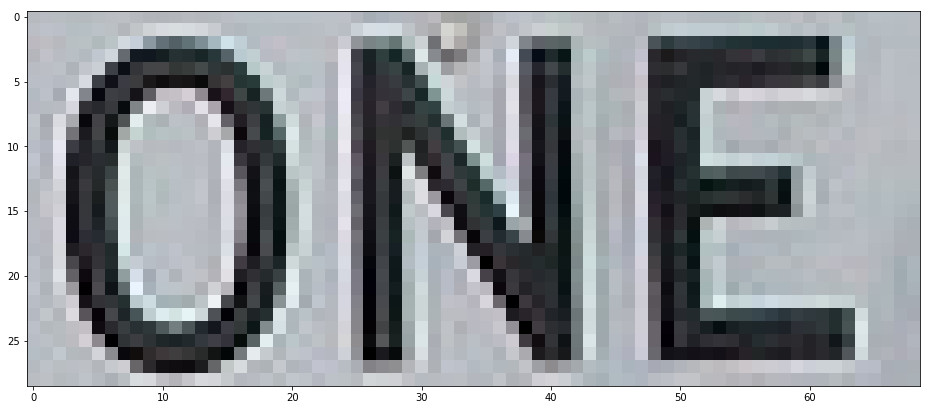

In [280]:
for r in range(10):
    train = writer.ShardWriter(f"coco-text-affine-{r:03d}-train-%06d.tar")
    val = writer.ShardWriter(f"coco-text-affine-{r:03d}-val-%06d.tar")
    l = list(good)
    random.shuffle(l)
    for index, an in enumerate(l):
        x, y, w, h = [int(q) for q in an['bbox']]
        s = "val" if "val" in an['file_name'] else "train"
        image = imread(f"/data1/coco-extract/{s}2014/{an['file_name']}")
        try:
            sub = extract_masked(image, an["mask"])
        except Exception as e:
            print(r, index, e)
            continue
        key = re.sub(r"(?i)\.(png|jpg)$", "", an["file_name"])+f"/{x},{y},{w},{h}"
        sample = dict(__key__=key, png=sub, text=an["utf8_string"])
        if an["set"]=="val":
            val.write(sample)
        else:
            train.write(sample)
        if index%1000==0: print(index, key, sub.shape, sample["text"], file=sys.stderr)
        #break

    val.close()
    train.close()
    #break

imshow(sub)

In [147]:
!ls

Untitled.ipynb			       coco-text-affine-006-val-000000.tar
coco-detect-train-000000.tar	       coco-text-affine-007-train-000000.tar
coco-detect-train-000001.tar	       coco-text-affine-007-val-000000.tar
coco-detect-val-000000.tar	       coco-text-affine-008-train-000000.tar
coco-text-affine-000-train-000000.tar  coco-text-affine-008-val-000000.tar
coco-text-affine-000-val-000000.tar    coco-text-affine-009-train-000000.tar
coco-text-affine-001-train-000000.tar  coco-text-affine-009-val-000000.tar
coco-text-affine-001-val-000000.tar    coco-text-rect-train-000000.tar
coco-text-affine-002-train-000000.tar  coco-text-rect-val-000000.tar
coco-text-affine-002-val-000000.tar    coco-text-rot-train-000000.tar
coco-text-affine-003-train-000000.tar  coco-text-rot-val-000000.tar
coco-text-affine-003-val-000000.tar    coco-to-shards.ipynb
coco-text-affine-004-train-000000.tar  cocotext-nice.v2.json
coco-text-affine-004-val-000000.tar    cocotext-to-detection-shards.ipynb
coco-text-affine-005-t

In [148]:
pwd

'/data19/cocotext'